# Motion-Blurred Shape Recognition Playground

## Exploring methods for recognizing and analyzing shapes from motion-blurred images  
*Based on Caglioti and Giusti (2010)*

- biagio.cancelliere@mail.polimi.it
- davide1.franchi@mail.polimi.it
- carlos2.ruiz@mail.polimi.it

## Table of Contents

1. **[Introduction and Motivation](#introduction-and-motivation)**  
2. **[Background and Theoretical Foundations](#background-and-theoretical-foundations)**  
3. **[Dataset and Example Images](#dataset-and-example-images)**  
4. **[Interactive Gradient Exploration: Sobel Filter](#interactive-gradient-exploration-sobel-filter)**  
5. **[Interactive Edge Detection: Canny Filter](#interactive-edge-detection-canny-filter)**  
6. **[Conclusions and Future Work](#conclusions-and-future-work)**  
7. **[References](#references)**  

## 1. Introduction <a name="introduction"></a>

Natural image matting is the process of estimating the opacity (alpha value) of the foreground object in an image, separating it from the background. This task is essential in many applications, including image editing, film production, augmented reality, and compositing.

The **alpha matte** is a real-valued mask $ \alpha(x, y) \in [0, 1] $ that indicates the proportion of foreground present at each pixel:
- $ \alpha = 1 $: full foreground
- $ \alpha = 0 $: full background
- $ \alpha \in (0,1) $: partial or mixed pixels (e.g., along object boundaries or in regions of transparency)

Estimating an accurate alpha matte from a single image is highly ill-posed. To resolve this ambiguity, additional constraints are needed. One widely adopted approach is to use **user-provided annotations**, such as:
- **Scribbles** indicating known foreground and background pixels
- **Trimaps** that mark definite foreground, background, and unknown regions

In this notebook, we focus on the method proposed by **Levin et al. (2008)**, which formulates image matting as a **closed-form solution** by leveraging the local color distribution of the image. Their method constructs a **Matting Laplacian**, a sparse matrix that enforces smoothness of the alpha matte within small windows under a color line model.

Given a small set of user-defined scribbles, the method solves a sparse linear system to propagate alpha values across the image, producing a soft, edge-preserving alpha matte.

This notebook walks through the complete pipeline:
- Interpreting user scribbles as alpha constraints
- Constructing the matting Laplacian
- Solving for the alpha matte via linear system optimization
- Visualizing and interpreting the resulting alpha mask


## 2. Setup and Dependencies <a name="setup-and-dependencies"></a>

This section installs and imports the necessary Python libraries for image processing, numerical computation, and visualization.

Make sure to run this cell before proceeding.


In [1]:
# Install required packages (if not already available)
# Uncomment the following line if running in a clean environment (e.g., Colab)
# !pip install opencv-python-headless scipy matplotlib

import numpy as np
import cv2
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

# Configure plots for consistent visual output
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False

# Utility for displaying images
def imshow(img, title=None, cmap=None):
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        # OpenCV uses BGR; convert to RGB for display
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


## 3. Data Preparation <a name="data-preparation"></a>

To compute the alpha matte, we need two input images:

- The **original RGB image** containing the object to be segmented.
- A corresponding **scribbles image**, where the user has marked some pixels as definite foreground (typically white) and definite background (typically black).

The scribbles act as soft constraints that guide the matting algorithm.

The input and scribbles images must:
- Have the same dimensions
- Be in color (3-channel RGB/BGR)
- Be properly aligned

We will now load both images and display them to verify their correctness.


### 3.1 Loading the Input Image and Scribbles <a name="loading-the-input-image-and-scribbles"></a>


In [2]:
from typing import Tuple, Union

def _resize_pair(img: np.ndarray, scrib: np.ndarray, max_dim: Union[int, None]) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    If max_dim is not None and either dimension exceeds max_dim,
    compute a scale factor and resize both img and scrib to that scale,
    preserving aspect ratio. Returns (img_resized, scrib_resized, scale_factor).
    """
    h, w = img.shape[:2]
    if max_dim is None or max(h, w) <= max_dim:
        return img, scrib, 1.0

    scale = max_dim / max(h, w)
    new_size = (int(w * scale), int(h * scale))
    img_resized = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    scrib_resized = cv2.resize(scrib, new_size, interpolation=cv2.INTER_AREA)
    return img_resized, scrib_resized, scale

# Load fan image and scribbles (invert the path definitions for changing images)
image_path = "../assets/images/IMG_9264.png"
scribbles_path = "../assets/scribbles/IMG_9264_scribbles_hard.png"

# Load scraper image and scribbles
image_path = "../assets/images/IMG_1143.png"
scribbles_path = "../assets/scribbles/flyingball.png.png"

image_path = "../assets/images/flyingball.png"
scribbles_path = "../assets/scribbles/flyingball_scribbles.png"

image_raw = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
scribbles_raw = cv2.imread(scribbles_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0

# Sanity check
assert image_raw is not None and scribbles_raw is not None, "Failed to load input images"
assert image_raw.shape == scribbles_raw.shape, "Image and scribbles must have the same dimensions"

# Resize if necessary
max_dim = 512  # Set maximum size for either dimension
image, scribbles, scale = _resize_pair(image_raw, scribbles_raw, max_dim)

print(f"Original shape: {image_raw.shape[:2]}, resized to: {image.shape[:2]}, scale factor: {scale:.3f}")


Original shape: (1317, 1170), resized to: (512, 454), scale factor: 0.389


### 3.2 Visualizing the Inputs <a name="visualizing-the-inputs"></a>


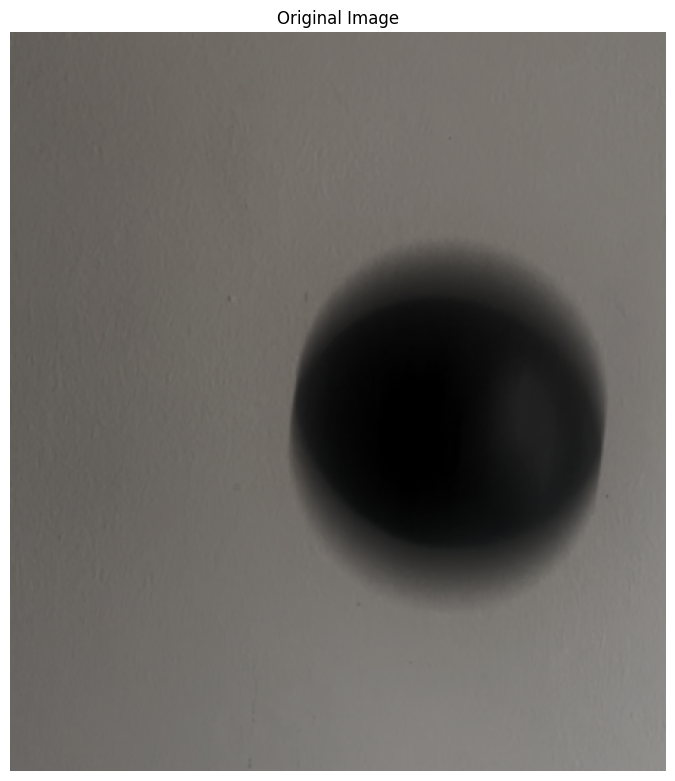

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


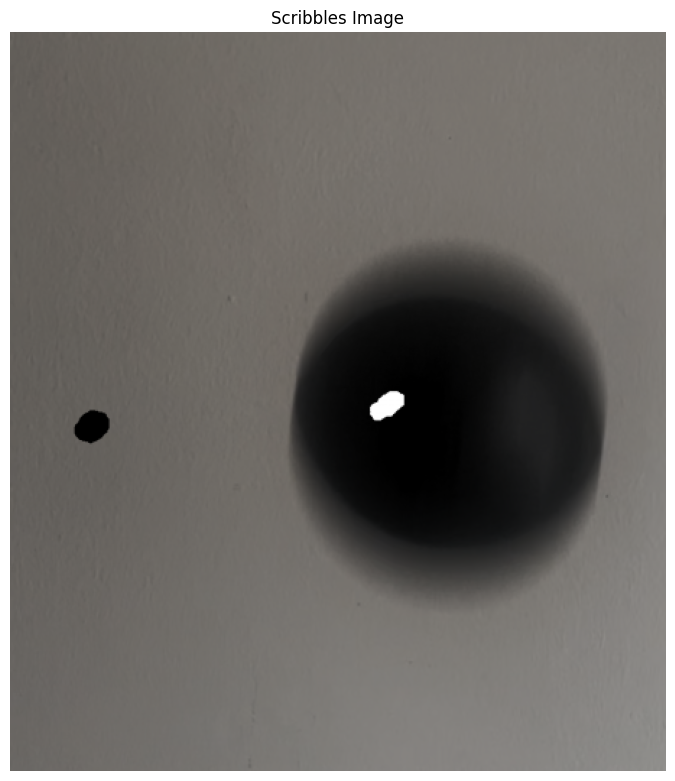

In [3]:
# Display original image
plt.figure(figsize=(12.8, 9.6))
imshow(image, "Original Image")
plt.show()

# Display scribbles overlay
plt.figure(figsize=(12.8, 9.6))
imshow(scribbles, "Scribbles Image")
plt.show()


## 4. Alpha Prior from Scribbles <a name="alpha-prior-from-scribbles"></a>

The matting algorithm requires an initial estimate of the alpha values—called the **alpha prior**—to guide the solution. This prior is derived directly from the scribbles image provided by the user.

### Interpretation of Scribbles

We assume the scribbles image consists of:
- **Black strokes** (RGB ≈ [0, 0, 0]) marking definite background
- **White strokes** (RGB ≈ [1, 1, 1]) marking definite foreground
- **Unmodified areas** (same as original image) representing unknown regions

We compute the alpha prior $\alpha_0(x, y)$ for each pixel using the formula:

$$
\alpha_0(x, y) = \frac{1}{2} \cdot \text{sign} \left( \sum_{c=1}^{3} (S_c(x, y) - I_c(x, y)) \right) + 0.5
$$

Where:
- $ S(x, y) $: the scribbles image
- $ I(x, y) $: the original image
- The result maps to:
  - $ \alpha_0 = 1 $: foreground (white scribble)
  - $ \alpha_0 = 0 $: background (black scribble)
  - $ \alpha_0 = 0.5 $: unknown (no scribble)

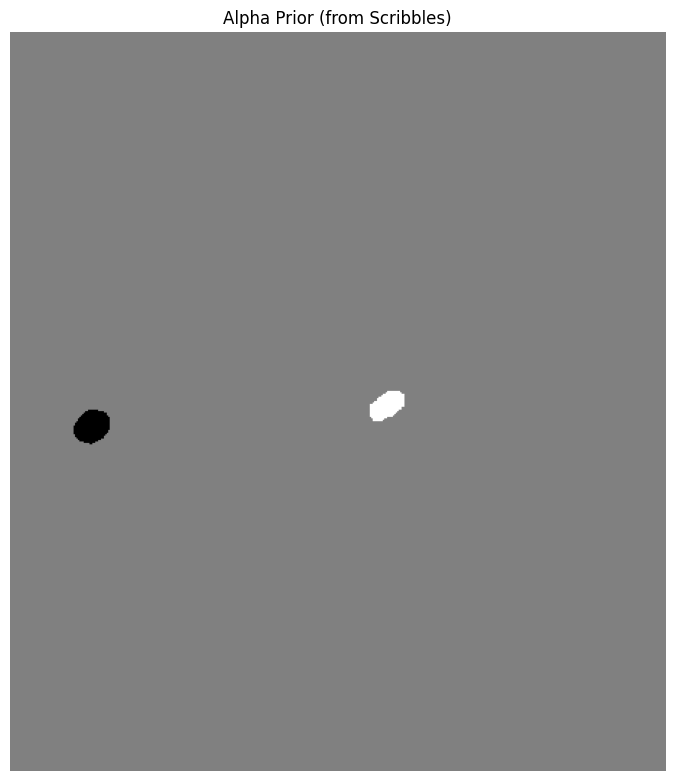

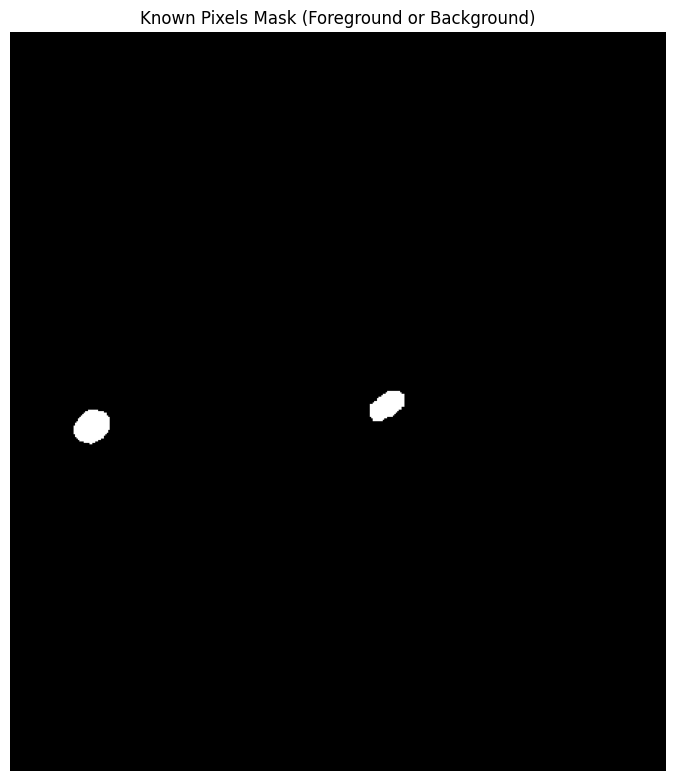

In [4]:
# Compute alpha prior from scribbles
prior = np.sign(np.sum(scribbles - image, axis=2)) / 2.0 + 0.5

# Define constant mask: where prior is either 0 or 1 (i.e., where user actually painted)
consts_map = (prior != 0.5).astype(np.float32)

# Display prior
plt.figure(figsize=(12.8, 9.6))
imshow(prior, "Alpha Prior (from Scribbles)", cmap="gray")
plt.show()

# Optionally visualize where scribbles exist (binary mask)
plt.figure(figsize=(12.8, 9.6))
imshow(consts_map, "Known Pixels Mask (Foreground or Background)", cmap="gray")
plt.show()


## 5. Matting Laplacian Construction <a name="matting-laplacian-construction"></a>

The **Matting Laplacian** is a key component of the Closed-Form Matting method proposed by Levin et al. It encodes the assumption that, within a small window, the colors of pixels lie approximately on a single line in RGB space. Based on this assumption, the Laplacian enforces that the estimated alpha values should vary smoothly in regions with homogeneous color, and should respect edges in the image.

Formally, the Matting Laplacian $ L $ is a sparse $ N \times N $ matrix (where $ N = H \times W $) that penalizes differences in alpha values between similar pixels in a local window.

### Window Definition

For each pixel, we consider a local square window of size $ (2r+1) \times (2r+1) $, typically with radius $ r = 1 $, i.e., a $ 3 \times 3 $ window.

For each window $ \omega_k $, the local contribution to the Laplacian is:

$$
L_{ij}^{(k)} = \delta_{ij} - \frac{1}{|\omega_k|} \left( 1 + (I_i - \mu_k)^T \left( \Sigma_k + \frac{\epsilon}{|\omega_k|} I_3 \right)^{-1} (I_j - \mu_k) \right)
$$

Where:
- $ I_i, I_j $: RGB values at pixels $ i $ and $ j $ within the window
- $ \mu_k $, $ \Sigma_k $: mean and covariance of RGB values in the window
- $ \epsilon $: small regularization constant (e.g., $10^{-7}$)

The total Laplacian is obtained by summing contributions over all overlapping windows.

### Computation Notes
- The Laplacian is implemented as a sparse matrix to scale to large images.
- We skip windows that are entirely inside known foreground/background regions (optional optimization).

We now define a function to compute the Laplacian matrix for a given image.


In [5]:
from numpy.lib.stride_tricks import as_strided

def _rolling_block(A, block=(3, 3)):
    """Extracts all (3x3) windows from matrix A using strides."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = A.strides * 2
    return as_strided(A, shape=shape, strides=strides)

def compute_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))

    # rewrite L in CSR format
    #L = scipy.sparse.csr_matrix((nz_indsVal, nz_indsCol, np.arange(0, nz_indsVal.shape[0] + 1, win_size)), shape=(h*w, h*w))
    return L.tocsr()


### 5.1 Computing and Visualizing the Laplacian

Once the Matting Laplacian construction function is in place, we can compute it for our specific image. To optimize performance and focus only on the unknown regions, we apply the Laplacian only to pixels where the alpha value is not already known from the scribbles (i.e., where the prior is equal to 0.5).

This section also visualizes the sparsity structure of the resulting Laplacian matrix. This visualization provides insight into how local pixel interactions are encoded—each row in the Laplacian corresponds to a pixel, and its non-zero entries define which neighboring pixels influence its alpha value.

A correctly formed Laplacian should:
- Be symmetric and positive semi-definite
- Contain non-zero entries mainly along and near the diagonal
- Exhibit a repeating banded structure due to window-based neighborhood interactions


Laplacian shape: (232448, 232448)
Non-zero entries: 5,772,039


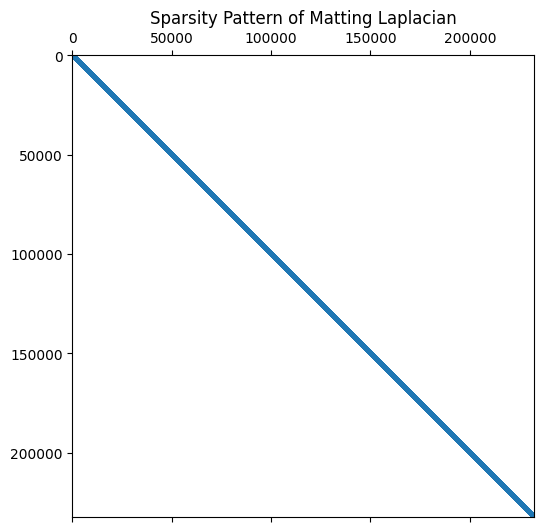

In [6]:
# Compute mask of unconstrained pixels (where alpha is unknown)
unconstrained_mask = (prior == 0.5).astype(np.uint8)

# Compute Laplacian only where needed
L = compute_laplacian(image, mask=unconstrained_mask)

print(f"Laplacian shape: {L.shape}")
print(f"Non-zero entries: {L.nnz:,}")
plt.spy(L, markersize=0.1)
plt.title("Sparsity Pattern of Matting Laplacian")
plt.show()


Due to the large size and high sparsity of the Matting Laplacian, a full-matrix visualization can appear nearly empty except for the main diagonal. To better understand its internal structure, we can zoom into a small top-left portion of the matrix—for example, the first 1000×1000 entries.

This zoomed view allows us to:

- Confirm that each pixel is connected to its local neighbors (e.g., through 3×3 windows)
- Observe the banded pattern around the diagonal
- Validate that the Laplacian encodes local connectivity and smoothness assumptions as expected

Keep in mind:
- The diagonal represents each pixel’s connection to itself
- The off-diagonal bands represent connections to nearby pixels (based on windowed neighborhoods)
- The vertical distance between bands is approximately equal to the image width, due to raster row-major ordering

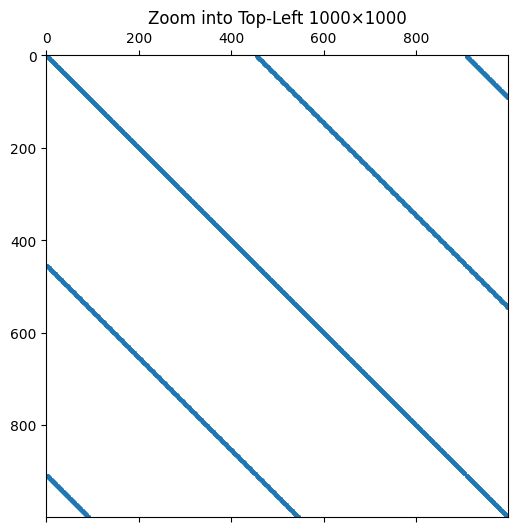

In [7]:
submatrix = L[:1000, :1000]
plt.spy(submatrix, markersize=1)
plt.title("Zoom into Top-Left 1000×1000")
plt.show()


## 6. Solving for the Alpha Matte <a name="solving-for-the-alpha-matte"></a>

With the Matting Laplacian $ L $ constructed and the alpha prior $ \alpha_0 $ defined from user scribbles, we now solve for the full alpha matte.

We minimize the following quadratic energy:

$$
\alpha^{*} = \arg\min_{\alpha} \; \alpha^\top L \alpha + (\alpha - \alpha_0)^\top C (\alpha - \alpha_0)
$$

Where:
- $ L $: the Matting Laplacian (enforces smoothness and local color consistency)
- $ \alpha_0 $: prior values (0, 0.5, or 1) derived from scribbles
- $ C $: diagonal confidence matrix (high confidence in scribbled pixels, zero elsewhere)

This results in a sparse linear system:

$$
(L + C)\, \alpha = C\, \alpha_0
$$

which we solve using a sparse direct solver.

The solution is a real-valued alpha matte $ \alpha(x, y) \in [0, 1] $ that respects user annotations while smoothly interpolating unknown regions based on the image structure.


Solving sparse linear system...


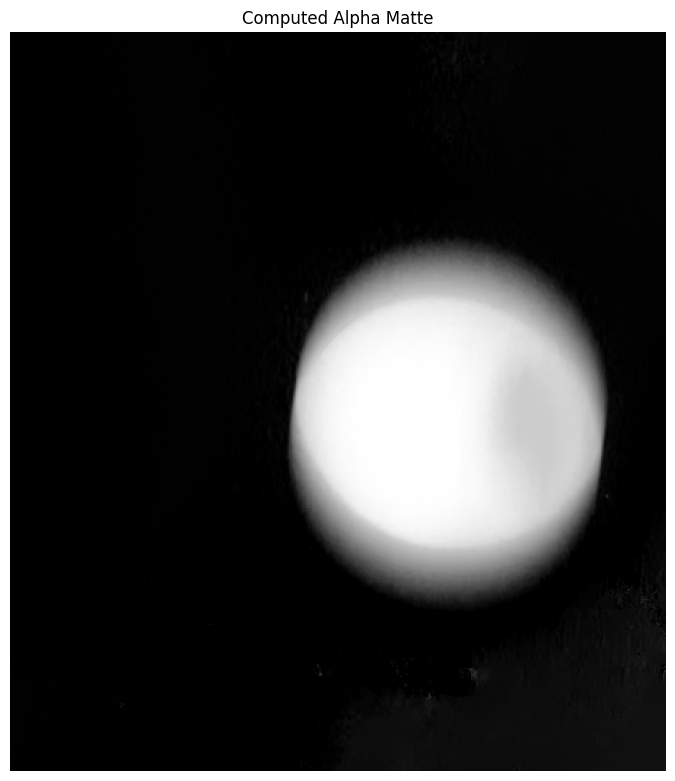

In [8]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Flattened versions
H, W = image.shape[:2]
N = H * W

# Confidence matrix: high (e.g. 100) where scribbles exist, zero elsewhere
confidence = 100.0
confidence_mask = (prior != 0.5).astype(np.float32)
C = diags((confidence * confidence_mask).ravel(), format="csr")

# Right-hand side: C * alpha_0
b = (confidence * confidence_mask * prior).ravel()

# Solve the sparse linear system: (L + C) α = C α₀
print("Solving sparse linear system...")
alpha_flat = spsolve(L + C, b)

# Clip to [0, 1] and reshape to image
alpha = np.clip(alpha_flat.reshape((H, W)), 0, 1)

# Show result
plt.figure(figsize=(12.8, 9.6))
imshow(alpha, "Computed Alpha Matte", cmap="gray")
plt.show()


## 7. Result Visualization and Analysis <a name="result-visualization-and-analysis"></a>

Once the alpha matte has been computed, we can visualize and analyze its quality in several ways:

1. **View the alpha matte directly**: this shows soft transitions around object boundaries and how well the scribbles propagated.
2. **Visualize the alpha overlayed on the original image**: this helps confirm whether alpha values align with object contours.
3. **Composite the foreground over a new background**: for example, a solid white or transparent background to simulate cutout.

This section provides practical tools to evaluate how well the alpha map separates foreground from background.


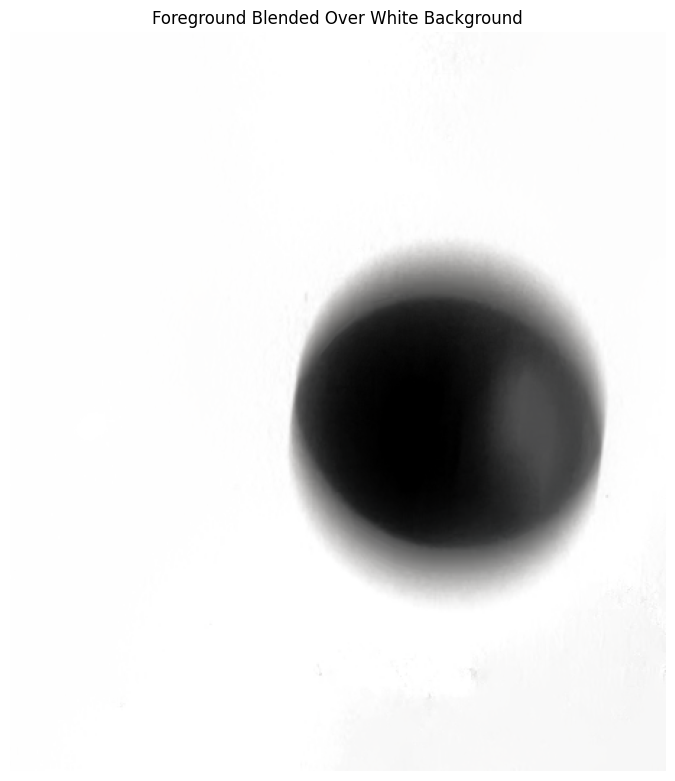

In [9]:
# Simple alpha blending: image * alpha + white * (1 - alpha)
foreground_rgb = image * alpha[..., np.newaxis] + (1 - alpha[..., np.newaxis]) * 1.0
foreground_rgb = foreground_rgb.astype(np.float32)

plt.figure(figsize=(12.8, 9.6))
imshow(foreground_rgb, "Foreground Blended Over White Background")
plt.show()


## 8. Conclusions and Further Reading <a name="conclusions-and-further-reading"></a>

In this notebook, we implemented and applied the **Closed-Form Matting** algorithm for natural images using sparse user annotations in the form of foreground/background scribbles.

### Key Takeaways

- The method computes a **soft alpha matte** $ \alpha(x, y) \in [0, 1] $, which smoothly separates foreground from background, especially around complex object boundaries.
- Scribbles are interpreted as **hard constraints** that are propagated across the image using a **Matting Laplacian**, which encodes local color consistency.
- Solving the system involves sparse linear algebra and benefits from the matrix's structure: sparse, symmetric, and positive semi-definite.
- The resulting alpha matte can be directly used for **object extraction, compositing, or visual effects**.

### Strengths

- Requires minimal user input (a few scribbles).
- Fully differentiable and fast (no iterative optimization).
- Produces smooth and realistic mattes even for soft edges.

### Limitations

- Assumes local color smoothness, which may fail in highly textured or low-contrast regions.
- Sensitive to incorrect or sparse scribbles in ambiguous areas.
- Not designed for real-time video or dynamic content without additional extensions.

## 1. Introduction and Motivation

### What information does motion blur provide?

Motion blur occurs when an object moves during the camera's exposure period, creating a visible smear in the captured image. While traditionally considered a limitation in photography, blurred smears can actually encode valuable information about the object's shape and motion characteristics.

The original research by Caglioti and Giusti (2010) leverages these blurred smears to extract detailed geometric and temporal information, such as the object's initial and final contours, motion trajectories, and even intermediate shapes. This notebook aims to explore practical methods inspired by their approach, demonstrating how we can effectively recognize and reconstruct shapes directly from blurred images, thus turning a common photographic artifact into a useful source of visual data.

## 2. Background and Theoretical Foundations

### Motion blur, alpha matting, and geometric interpretation

When an object moves during a camera's exposure time, its projection sweeps across the image plane, resulting in a motion-blurred appearance. This blurred region—called a *smear*—can be interpreted as a semitransparent layer, where the **alpha value** at each pixel corresponds to the fraction of time the object covered that pixel.

The image formation process in this context can be modeled using the **Porter-Duff alpha compositing equation**:

$$
C(p) = \alpha(p) \cdot o(p) + (1 - \alpha(p)) \cdot B(p)
$$

where:

$$
\begin{aligned}
C(p) &\quad \text{is the observed intensity at pixel } p \\\\
o(p) &\quad \text{is the object’s intensity} \\\\
B(p) &\quad \text{is the background intensity} \\\\
\alpha(p) &\in [0, 1] \quad \text{is the proportion of exposure during which the object covers } p
\end{aligned}
$$

The gradient of the alpha matte, denoted as $ \nabla \alpha $
contains crucial structural cues:

- Discontinuities in $ \nabla \alpha $ align with changes in the object’s apparent contour.
- Iso-alpha curves trace the contour at specific instants within the exposure.

This theoretical framework allows one to:

- Identify the object's initial and final contours.
- Estimate envelopes of motion.
- Infer local motion dynamics (e.g., impacts, corners, speed changes).

Understanding these principles forms the foundation for the shape recognition techniques implemented in the rest of this notebook.


## 3. Dataset and Example Images

### Description of the image (`IMG_9264.png`)

To explore motion-blurred shape recognition techniques, we work with a set of sample images captured under controlled motion conditions. The primary image used in this notebook, `IMG_9264.png`, belongs to a sequence in which a ceiling fan moves rapidly across the scene, producing a visible motion blur. It exhibits characteristic streaks and transparency variations caused by object displacement during exposure, making it a suitable candidate for testing shape extraction methods.

Before applying any filters or computational steps, we load and visualize the image to assess its resolution, structure, and blur properties.

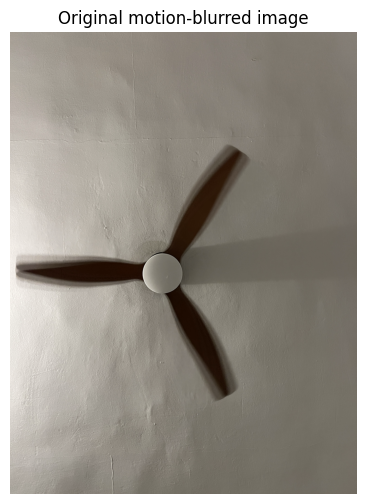

In [10]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../assets/images/IMG_9264.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title("Original motion-blurred image")
plt.axis('off')
plt.show()



### Additional example: `flyingball.png`

The image `flyingball.png` shows a dark spherical object in motion against a flat, uniform background. The object appears blurred along its motion direction, resulting in a soft-edged contour and a semi-transparent gradient toward the motion trail. This type of image is particularly relevant for testing the extraction of iso-alpha curves, envelope contours, and identifying region boundaries without the need for full alpha matte recovery. Its high contrast and simple background make it ideal for gradient-based techniques.

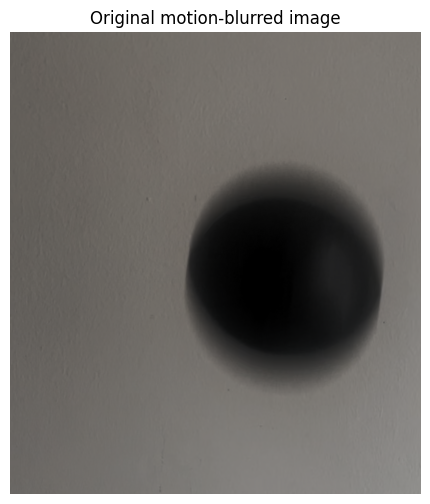

In [11]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../assets/images/flyingball.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title("Original motion-blurred image")
plt.axis('off')
plt.show()



## 4. Interactive Gradient Exploration: Sobel Filter

### Identifying contours with Sobel filters

This section introduces an interactive visualization tool for analyzing how different gradient-based parameters affect contour detection in motion-blurred images.

By applying the Sobel operator to a grayscale version of the input image, we compute the gradient magnitude, which highlights regions with strong intensity changes—typically corresponding to edges and boundaries of the moving object. Before applying the Sobel filter, a Gaussian blur is optionally used to suppress high-frequency noise.

The interface allows the user to experiment with:
- the size and standard deviation of the Gaussian kernel,
- the derivative order in the x and y directions,
- the size of the Sobel kernel,
- normalization and inversion of the result,
- optional thresholding to produce a binary edge map,
- display options such as interpolation method and colormap.

This interactive approach supports visual intuition about the role of each parameter, and helps to identify suitable configurations for emphasizing features such as contour boundaries, envelope shapes, and iso-gradient regions in motion-blurred objects.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown

def show_gradient_interactive(
    gaussian_kernel: int = 5,
    gaussian_sigma: float = 1.0,
    sobel_dx: int = 1,
    sobel_dy: int = 1,
    sobel_ksize: int = 3,
    scale: float = 0.4,
    normalize: bool = True,
    invert: bool = True,
    umbralize: bool = False,
    interpolation: str = 'nearest',
    colormap: str = 'gray',
    dpi: int = 100,
    thresh_val: int = 250
):
    # 1) Leer y escalar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    if scale != 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

    # 2) Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (gaussian_kernel, gaussian_kernel), gaussian_sigma)

    # 3) Sobel en x e y
    gx = cv2.Sobel(img_blur, cv2.CV_64F, sobel_dx, 0, ksize=sobel_ksize)
    gy = cv2.Sobel(img_blur, cv2.CV_64F, 0, sobel_dy, ksize=sobel_ksize)
    mag = np.hypot(gx, gy)

    # 4) Normalizar a [0,255]
    if normalize:
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    mag = mag.astype(np.uint8)

    # 5) Invertir (opcional)
    if invert:
        mag = cv2.bitwise_not(mag)

    if umbralize:
        # 6) Umbralizar usando el valor ajustable
        _, mag = cv2.threshold(mag, thresh_val, 255, cv2.THRESH_BINARY)

    # 7) Mostrar resultado umbralizado
    plt.figure(figsize=(img.shape[1]/dpi, img.shape[0]/dpi), dpi=dpi)
    plt.imshow(mag, cmap=colormap, vmin=0, vmax=255, interpolation=interpolation)
    plt.title(
        f"Gk={gaussian_kernel} σ={gaussian_sigma:.1f} | "
        f"Sx={sobel_dx} Sy={sobel_dy} k={sobel_ksize} | "
        f"Threshold={thresh_val} | scale={scale} dpi={dpi}"
    )
    plt.axis('off')
    plt.show()

In [13]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(13, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(25, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.4, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(True, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)


interactive(children=(IntSlider(value=13, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

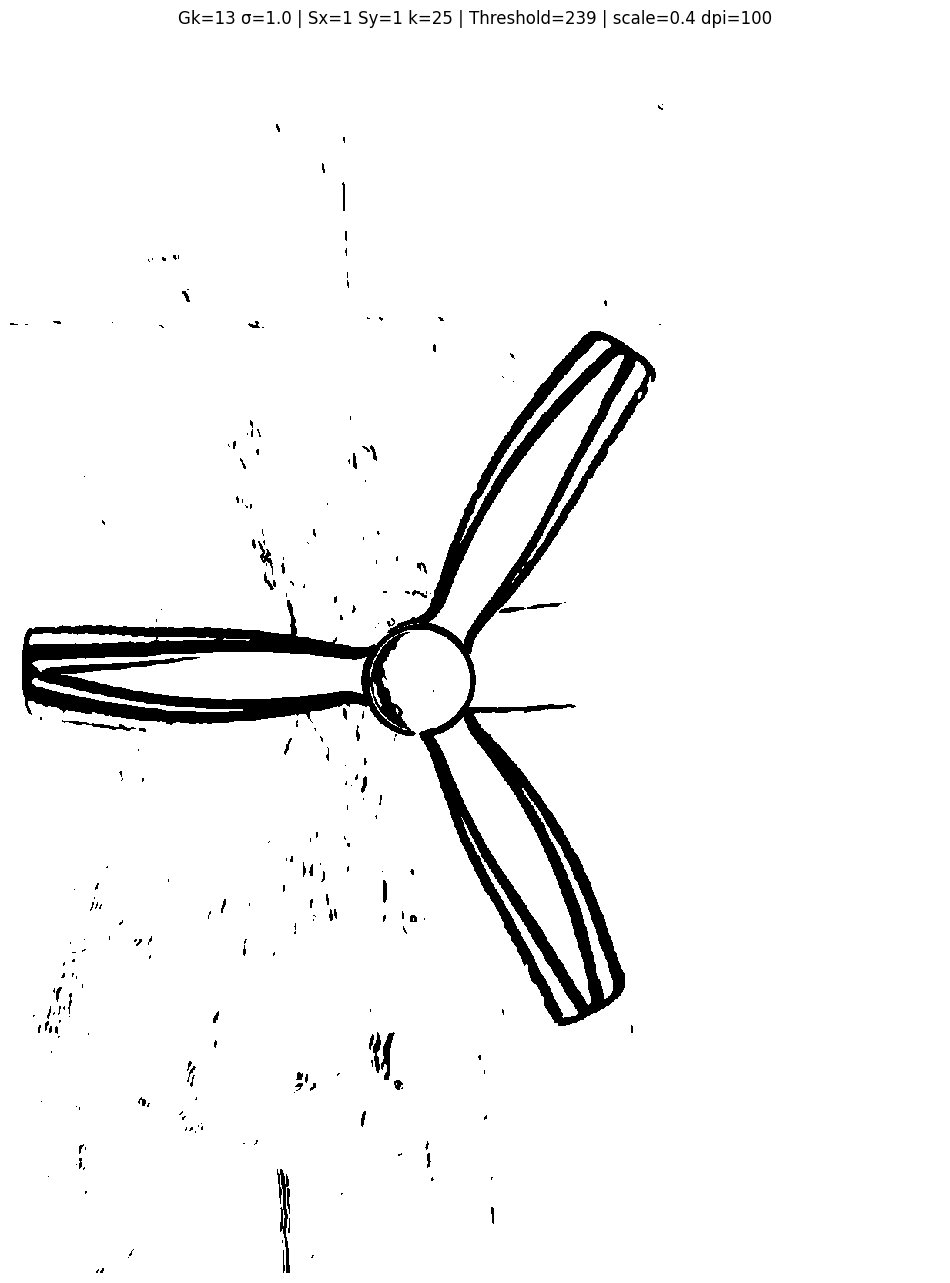

In [14]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(13, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(25, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.4, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(False, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)

interactive(children=(IntSlider(value=13, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

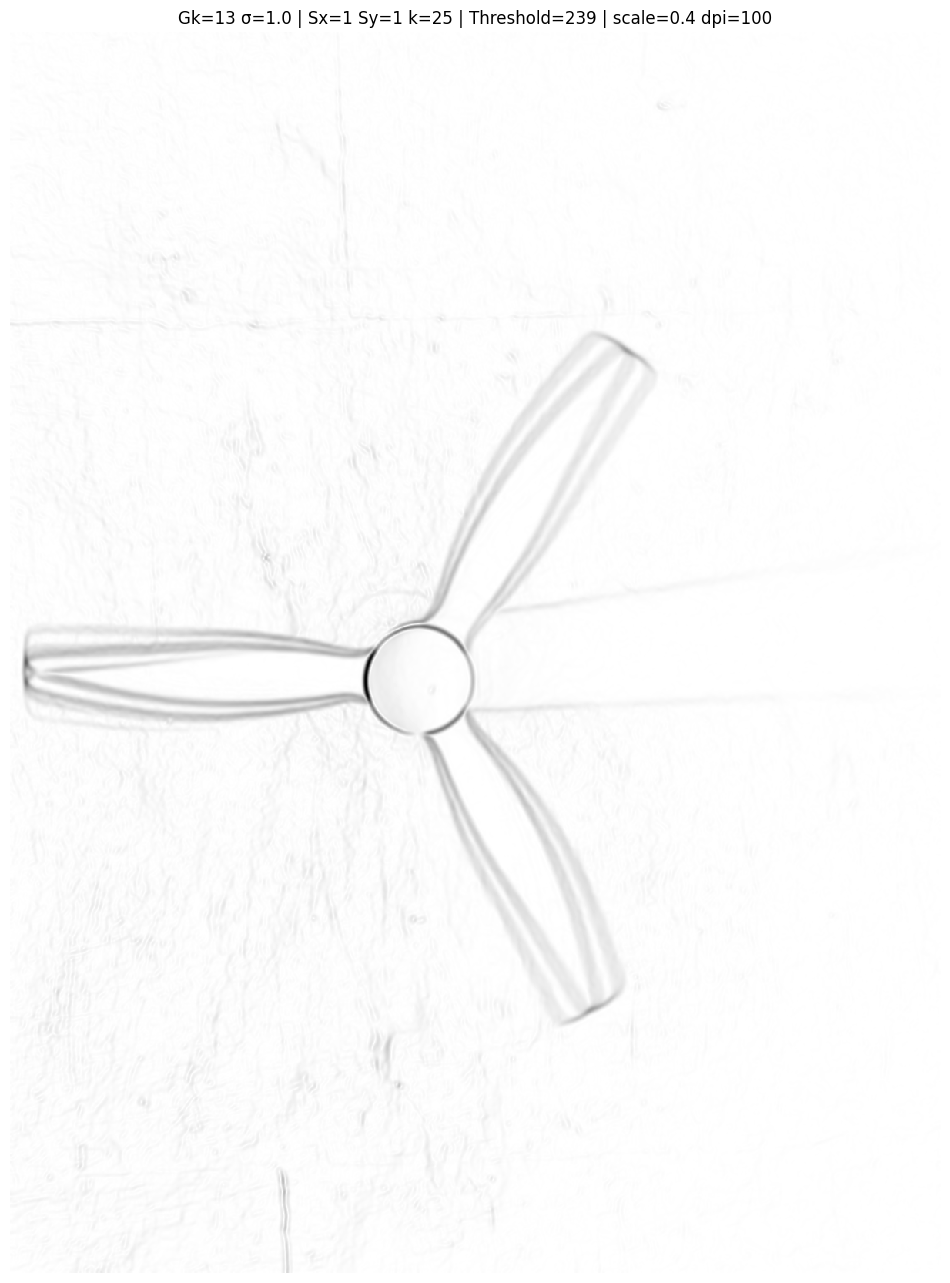

In [15]:
img_path = "../assets/images/flyingball.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(1, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(9, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.6, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(False, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)

interactive(children=(IntSlider(value=1, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0,…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

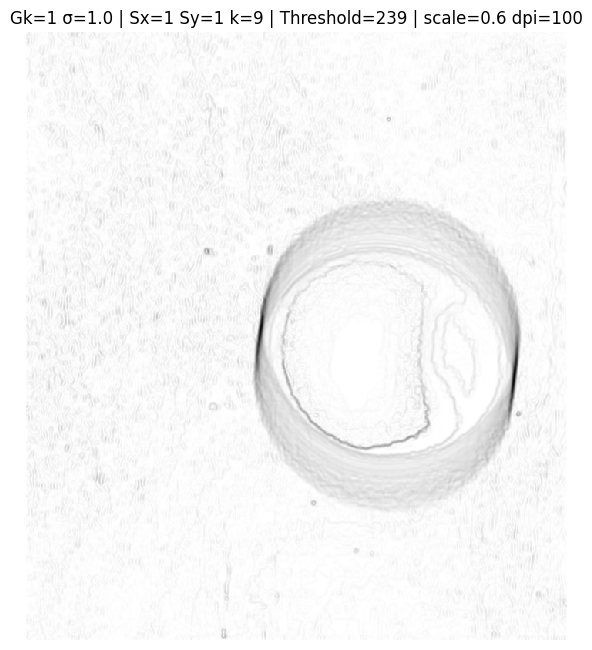

## 5. Interactive Edge Detection: Canny Filter

### Edge detection comparisons

In this section, we explore the application of the **Canny edge detector** as a tool for contour extraction in motion-blurred images.

Canny filtering is particularly effective at highlighting well-defined edges while suppressing noise, making it a strong candidate for identifying the outer boundaries of fast-moving objects captured with long exposure. By adjusting its parameters interactively—such as the low and high thresholds, Gaussian smoothing, and aperture size—we can observe how different configurations affect the visibility and continuity of the resulting contours.

Compared to gradient magnitude visualizations (as seen in the Sobel-based analysis in Section 4), the Canny filter provides a binary edge map that is often more selective, but may fail to capture subtle structures present in smoother transitions of blur. This makes it especially valuable for detecting:
- the initial and final apparent contours of a moving object,
- sharp structural transitions within the blur smear,
- high-contrast envelope boundaries.

Through interactive tuning, users can assess the filter's effectiveness and develop an intuition for its strengths and limitations in shape recovery tasks.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown

def show_canny_interactive(
    gaussian_kernel: int = 5,
    gaussian_sigma: float = 1.0,
    low_thresh: int = 50,
    high_thresh: int = 150,
    aperture_size: int = 3,
    L2gradient: bool = False,
    scale: float = 1.0,
    interpolation: str = 'nearest',
    colormap: str = 'gray',
    dpi: int = 100,
    invert: bool = True
):
    # 1) Leer y escalar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    if scale != 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        h, w = img.shape

    # 2) Suavizado Gaussiano (kernel impar)
    gk = gaussian_kernel | 1
    blur = cv2.GaussianBlur(img, (gk, gk), gaussian_sigma)

    # 3) Canny
    # aperture_size debe ser 3,5,7; forzamos impar y >=3
    ap = max(3, aperture_size | 1)
    canny = cv2.Canny(blur, low_thresh, high_thresh,
                      apertureSize=ap,
                      L2gradient=L2gradient)
    
    # 5) Invertir (opcional)
    if invert:
        canny = cv2.bitwise_not(canny)

    # 4) Mostrar sin márgenes
    fig = plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax = fig.add_subplot(111)
    ax.imshow(canny, cmap=colormap,
              vmin=0, vmax=255,
              interpolation=interpolation)
    ax.axis('off')
    ax.set_title(f"Gauss k={gk} σ={gaussian_sigma:.1f} | "
                 f"Canny low={low_thresh} high={high_thresh} | "
                 f"ap={ap} L2={L2gradient}")
    plt.show()

In [17]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_canny_interactive,
    gaussian_kernel=IntSlider(27,   min=1,  max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(2.0, min=0.0,max=10.0,step=0.5,description='σ Gauss'),
    low_thresh=IntSlider(255,  min=0,  max=255, step=1, description='Low Th'),
    high_thresh=IntSlider(255, min=0,  max=255, step=1, description='High Th'),
    aperture_size=IntSlider(5, min=3,  max=7,   step=1, description='Aperture'),
    L2gradient=Checkbox(True, description='L2 grad'),
    scale=FloatSlider(0.3, min=0.1, max=1.0, step=0.1, description='Scale'),
    interpolation=Dropdown(
        options=['nearest','bilinear','bicubic','antialiased'],
        value='nearest', description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray','viridis','hot','magma','inferno'],
        value='gray', description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI')
)


interactive(children=(IntSlider(value=27, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=2.0…

<function __main__.show_canny_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, low_thresh: int = 50, high_thresh: int = 150, aperture_size: int = 3, L2gradient: bool = False, scale: float = 1.0, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, invert: bool = True)>

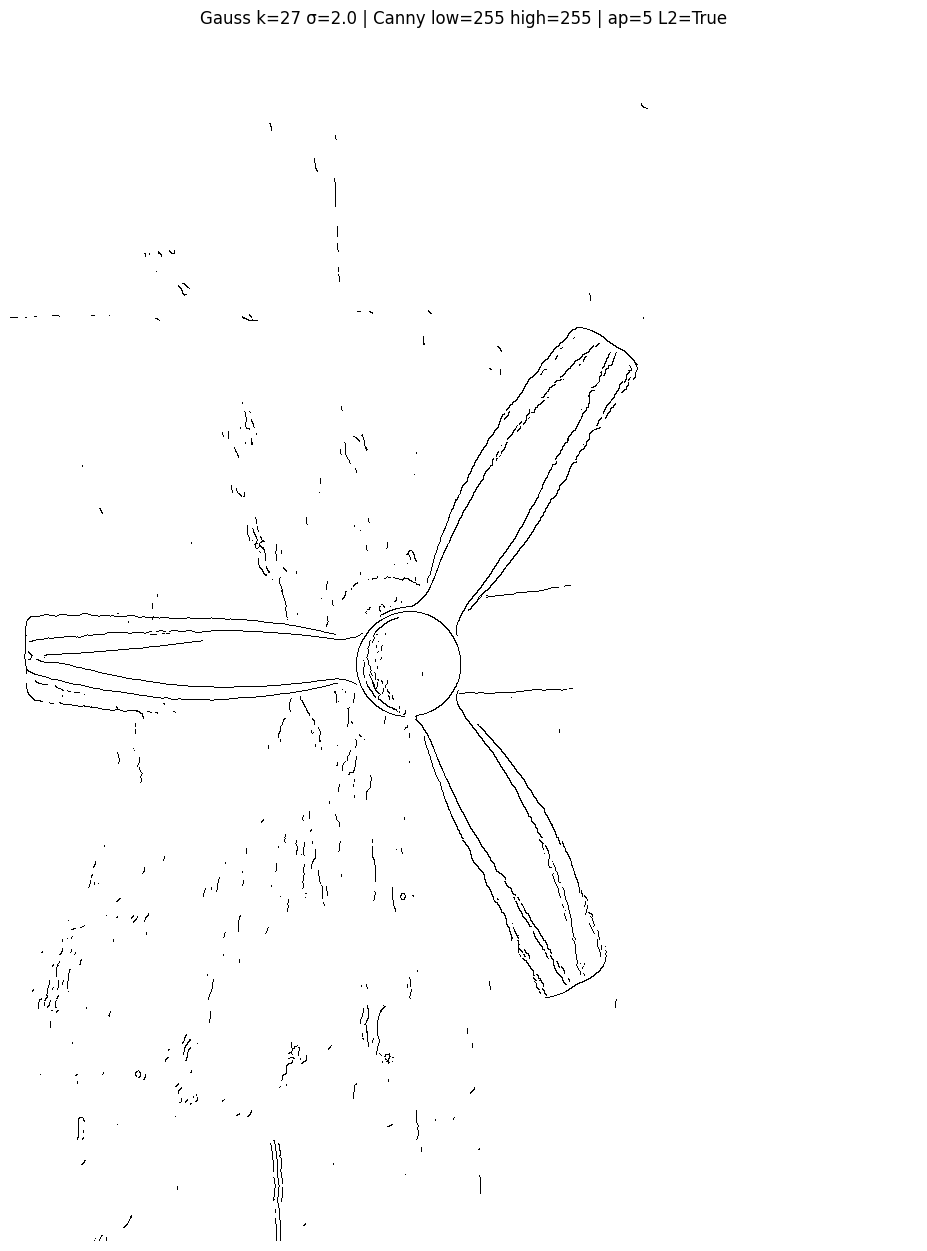

## 6. Conclusions

In this notebook, we explored the problem of shape recognition in motion-blurred images by analyzing gradient-based features and applying classical edge detection techniques. Building on the theoretical framework presented by Caglioti and Giusti (2010), we demonstrated that a significant amount of spatial and motion-related information can be extracted from a single blurred image—even without explicitly computing the alpha matte.

Through interactive experiments with Sobel and Canny filters, we showed how parameter tuning influences the visibility and continuity of object contours. These visualizations allowed us to:
- Approximate initial and final contours of the moving object.
- Identify envelope boundaries and gradient discontinuities.

While the absence of a true alpha matte limits the interpretability of finer motion structure, the use of gradient magnitude and edge detection provides a lightweight and practical method for extracting meaningful geometric features from motion-blurred imagery.